In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.cluster import SpectralCoclustering

sns.set(style='ticks', context='talk')
from matplotlib.patches import Rectangle

In [2]:
import patchseq_utils.analysis as utils
import patchseq_utils.plotting as plot
import patchseq_utils.shiny as shiny
from patchseq_utils.plot_umap import plot_umap_labeled

In [3]:
from patchseq_utils import l1_load
from patchseq_utils import util
from importlib import reload
reload(l1_load)
reload(util)

<module 'patchseq_utils.util' from '/home/tom.chartrand/work/patchseq_human_L1/patchseq_utils/util.py'>

In [4]:
from patchseq_utils.l1_load import *
from patchseq_utils.util import *

## New distance metric

In [5]:
import pyreadr
from sklearn.metrics import pairwise_distances
from umap import UMAP

In [6]:
aligned = pyreadr.read_r("../human_l1/scalign_coords.rda")['cca.dat']

In [7]:
shiny_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/MTG_paper_rev'
human_df = shiny._load_shiny_data(directory=shiny_dir)
shiny_dir = "/allen/programs/celltypes/workgroups/rnaseqanalysis/shiny/facs_seq/Mm_VISp_AIT2.3.0_20047_202005"
mouse_df = shiny._load_shiny_data(directory=shiny_dir)

human_df.cluster = human_df.cluster.map(shorten_name)
combined = pd.concat([
    human_df.set_index('sample_id')[['cluster',]].assign(species='human'),
    mouse_df.set_index('sample_id')[['cluster',]].assign(species='mouse'),
])

In [41]:
l1_types_mouse = ['Lamp5 Krt73','Lamp5 Lsp1',  'Lamp5 Plch2 Dock5', 'Lamp5 Ntn1 Npy2r',
        'Lamp5 Fam19a1 Tmem182', 'Lamp5 Fam19a1 Pax6', 'Sncg Vip Nptx2',
       'Vip Col15a1 Pde1a']

l1_types_human = ['PAX6 CDH12', 'PAX6 TNFAIP8L3', 'LAMP5 LCP2','LAMP5 DBP', 'LAMP5 NMBR', 
       'SST CHRNA4', 'ADARB2 MC4R', 'VIP TSPAN12', 'SST BAGE2', 'VIP PCDH20']

In [8]:
def get_distances(coords, index_row, index_col):
    col_within = index_col.apply(lambda x: pairwise_distances(coords.loc[x]).mean())
    row_within = index_row.apply(lambda x: pairwise_distances(coords.loc[x]).mean())

    d = [[pairwise_distances(coords.loc[index_col[x]], coords.loc[index_row[y]]).mean() 
               for x in index_col.index] for y in index_row.index]

    between = pd.DataFrame(d, columns=index_col.index, index=index_row.index)

    d2 = (row_within.values[:, np.newaxis] + col_within.values[np.newaxis, :])/2
    # max? geom mean?
    within = pd.DataFrame(d2, columns=index_col.index, index=index_row.index)
    return between, within


In [9]:
def get_l1_df(df, types_human=l1_types_human, types_mouse=l1_types_mouse,):
    extra = 'non-L1 types'
    df.loc[:,extra] = df.loc[:,df.columns.difference(types_mouse)].max(axis=1)
    df.loc[extra, :] = df.loc[df.index.difference(types_human), 
                              df.columns.difference([extra])].max(axis=0)
    
    types_human = list(types_human) + [extra]
    types_mouse = list(types_mouse) +[extra]
    return df.loc[types_human, types_mouse]

def plot_l1_hom(df, types_human=l1_types_human, types_mouse=l1_types_mouse, figsize=(4,4)):
    fig, ax = plt.subplots(figsize=figsize)
    df = get_l1_df(df, types_human=types_human, types_mouse=types_mouse)
    sns.heatmap(df, cmap=plt.cm.Blues, cbar_kws=dict(label='similarity'), ax=ax, square=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right',  rotation_mode='anchor')
    ax.set_xlabel('mouse types')
    ax.set_ylabel('human types')

In [10]:
coords = aligned
index_mouse = (mouse_df.
               loc[lambda df: df.sample_id.isin(aligned.index)].
               loc[lambda df: df.subclass.isin(['Lamp5', 'Vip', 'Sncg'])].
               groupby('cluster').sample_id.apply(list))
index_human = (human_df.
               loc[lambda df: df.sample_id.isin(aligned.index)].
               loc[lambda df: df.cell_subclass.isin(['LAMP5/PAX6/Other', 'VIP'])].
               groupby('cluster').sample_id.apply(list))

In [11]:
between, within = get_distances(coords, index_human, index_mouse)

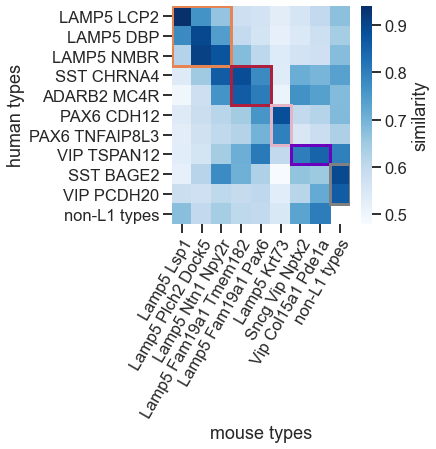

In [14]:
df = within/between
plot_l1_hom(df)
ax = plt.gca()
args = dict(linewidth=3, facecolor='none')
ax.add_patch(Rectangle((0,0), 3, 3, edgecolor=palette_subclass['LAMP5'], **args))
ax.add_patch(Rectangle((3,3), 2, 2, edgecolor=palette_subclass['MC4R'], **args))
ax.add_patch(Rectangle((5,5), 1, 2, edgecolor=palette_subclass['PAX6'], **args))
ax.add_patch(Rectangle((6,7), 2, 1, edgecolor=palette_subclass['L1 VIP'], **args))
ax.add_patch(Rectangle((8,8), 1, 2, edgecolor=palette_subclass['other'], **args))

In [15]:
human_df.replace()
human_df['homology_type'] = (human_df['cluster'].map(homology_mapping_human).
                             replace(['other', 'L1 VIP'], np.nan).
                             fillna(human_df['cluster']))
# human_df.loc[lambda df: df['homology_type'].isin(['other', 'VIP TSPAN12'])].assign(
#         homology_type=lambda df: df.cluster, inplace=True)
index_human_hom = (human_df.loc[lambda df: df.cell_subclass.isin(['LAMP5/PAX6/Other', 'VIP'])].
               groupby('homology_type').sample_id.apply(list))


In [16]:
between, within = get_distances(coords, index_col=index_mouse, index_row=index_human_hom)

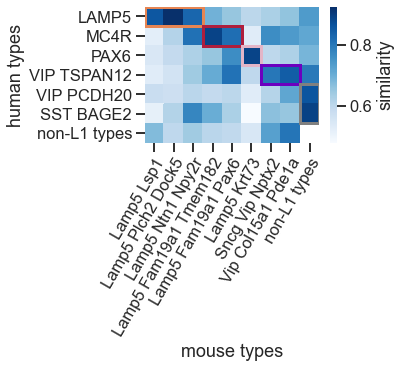

In [19]:
df = within/between
types_human = ['LAMP5', 'MC4R', 'PAX6', 'VIP TSPAN12', 'VIP PCDH20', 'SST BAGE2']
plot_l1_hom(df, types_human=types_human, figsize=(4,2.5))
ax = plt.gca()
args = dict(linewidth=3, facecolor='none')
ax.add_patch(Rectangle((0,0), 3, 1, edgecolor=palette_subclass['LAMP5'], **args))
ax.add_patch(Rectangle((3,1), 2, 1, edgecolor=palette_subclass['MC4R'], **args))
ax.add_patch(Rectangle((5,2), 1, 1, edgecolor=palette_subclass['PAX6'], **args))
ax.add_patch(Rectangle((6,3), 2, 1, edgecolor=palette_subclass['L1 VIP'], **args))
ax.add_patch(Rectangle((8,4), 1, 2, edgecolor=palette_subclass['other'], **args))

# plt.vlines([1,4,6,8], ymin=0, ymax=7, colors='k')

In [20]:
get_l1_df(df, types_human=types_human)

cluster,Lamp5 Lsp1,Lamp5 Plch2 Dock5,Lamp5 Ntn1 Npy2r,Lamp5 Fam19a1 Tmem182,Lamp5 Fam19a1 Pax6,Lamp5 Krt73,Sncg Vip Nptx2,Vip Col15a1 Pde1a,non-L1 types
homology_type,,,,,,,,,
LAMP5,0.857991,0.924072,0.830759,0.695576,0.654383,0.605200,0.627722,0.659535,0.739839
MC4R,0.523871,0.615642,0.811394,0.891440,0.817441,0.530467,0.766115,0.741542,0.716722
PAX6,0.547871,0.594129,0.625109,0.654276,0.764783,0.890393,0.603001,0.625393,0.689462
VIP TSPAN12,0.530998,0.564048,0.643605,0.708874,0.809922,0.601444,0.802306,0.846446,0.799240
VIP PCDH20,0.584134,0.576721,0.607317,0.593720,0.605100,0.530446,0.615242,0.718330,0.861109
SST BAGE2,0.518540,0.617803,0.777823,0.705291,0.627883,0.480039,0.666408,0.653509,0.893560
non-L1 types,0.676853,0.601308,0.641959,0.606975,0.598834,0.549555,0.729629,0.804458,NaN


### Alternatives

In [339]:

from scipy.spatial.distance import euclidean
def get_distances_centroid(coords):
    human_within = index_human.apply(lambda x: 
                                     pairwise_distances(coords.loc[x].mean(axis=0).values.reshape(1, -1), coords.loc[x]).mean())
    mouse_within = index_mouse.apply(lambda x: 
                                     pairwise_distances(coords.loc[x].mean(axis=0).values.reshape(1, -1), coords.loc[x]).mean())

    d = [[euclidean(coords.loc[index_human[x]].mean(axis=0), coords.loc[index_mouse[y]].mean(axis=0)) 
               for x in index_human.index] for y in index_mouse.index]

    between = pd.DataFrame(d, columns=index_human.index, index=index_mouse.index)

    d2 = (mouse_within.values[:, np.newaxis] + human_within.values[np.newaxis, :])
    within = pd.DataFrame(d2, columns=index_human.index, index=index_mouse.index)
    return between, within

In [340]:
between, within = get_distances_centroid(aligned)

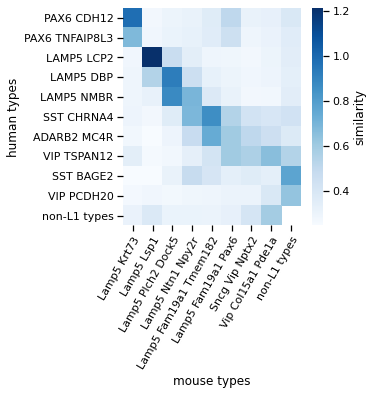

In [343]:
df = 1/between
plot_l1_hom(df.T)

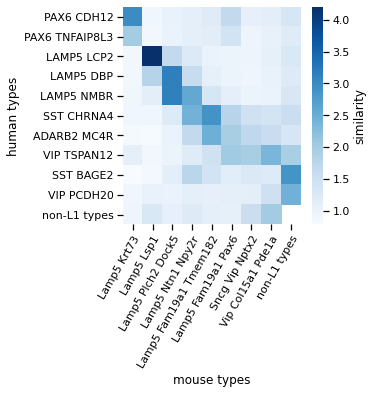

In [341]:
df = within/between
plot_l1_hom(df.T)

In [ ]:
umap = UMAP().fit_transform(aligned)

umap = pd.DataFrame(umap, index=aligned.index)

In [198]:
between, within = get_distances(umap)

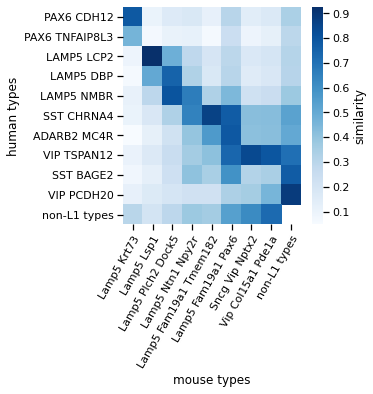

In [199]:
df = within/between
plot_l1_hom(df.T)

### UMAP vis

In [11]:
from umap import UMAP

In [12]:
umap = UMAP().fit_transform(aligned)

In [13]:
umap = pd.DataFrame(umap, index=aligned.index)

df = umap.join(combined)
df_l1 = df.loc[lambda df: df.cluster.isin(l1_types_human+l1_types_mouse)]

In [25]:
xlim=[-10,2.5]
ylim=[5,14]
axes=False
# xlim=[None, None]
# ylim=xlim
# axes=True

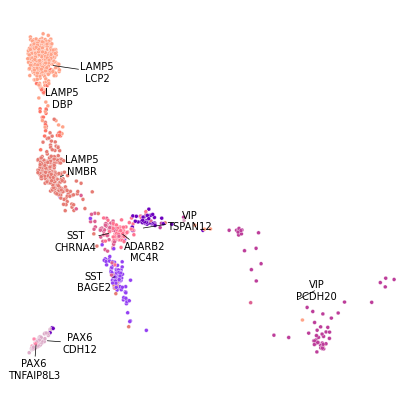

In [26]:
plot_umap_labeled(df_l1.query("species=='human'"), x=0, y=1, cluster='cluster', palette=palette_human, s=15,
                      figsize=(7,7), xlim=xlim, ylim=ylim, axes=axes)

/local1/storage/envs/ipfx3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


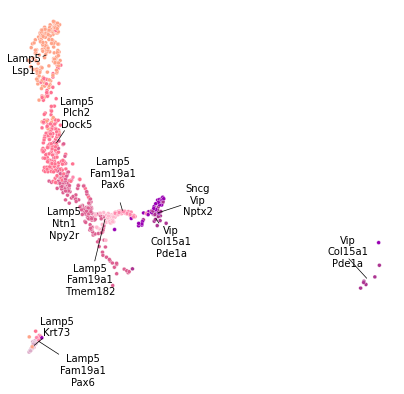

In [30]:
df_l1.loc[(df_l1.cluster=='Lamp5 Fam19a1 Pax6') & (df_l1[1]>7), 'cluster'] = "Lamp5 Fam19a1 Pax6 "
palette = palette_mouse
palette["Lamp5 Fam19a1 Pax6 "] = palette["Lamp5 Fam19a1 Pax6"]
df_l1.loc[(df_l1.cluster=='Vip Col15a1 Pde1a') & (df_l1[0]>0), 'cluster'] = 'Vip Col15a1 Pde1a '

palette['Vip Col15a1 Pde1a '] = palette['Vip Col15a1 Pde1a']
plot_umap_labeled(df_l1.query("species=='mouse'"), x=0, y=1, cluster='cluster', palette=palette, s=15,
                      figsize=(7,7), xlim=xlim, ylim=ylim, axes=axes)

Text(0, 0.5, '')

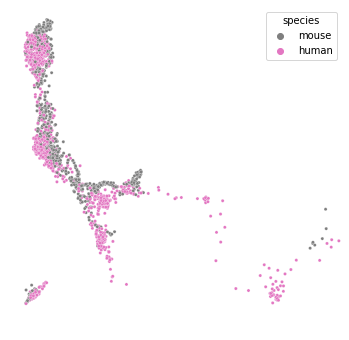

In [28]:
 plt.figure(figsize=(6,6))
sns.scatterplot(data=df_l1.sample(frac=1), x=0, y=1, hue='species', palette=species_palette, s=10, legend=True)
plt.xlim(xlim)
plt.ylim(ylim)
sns.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

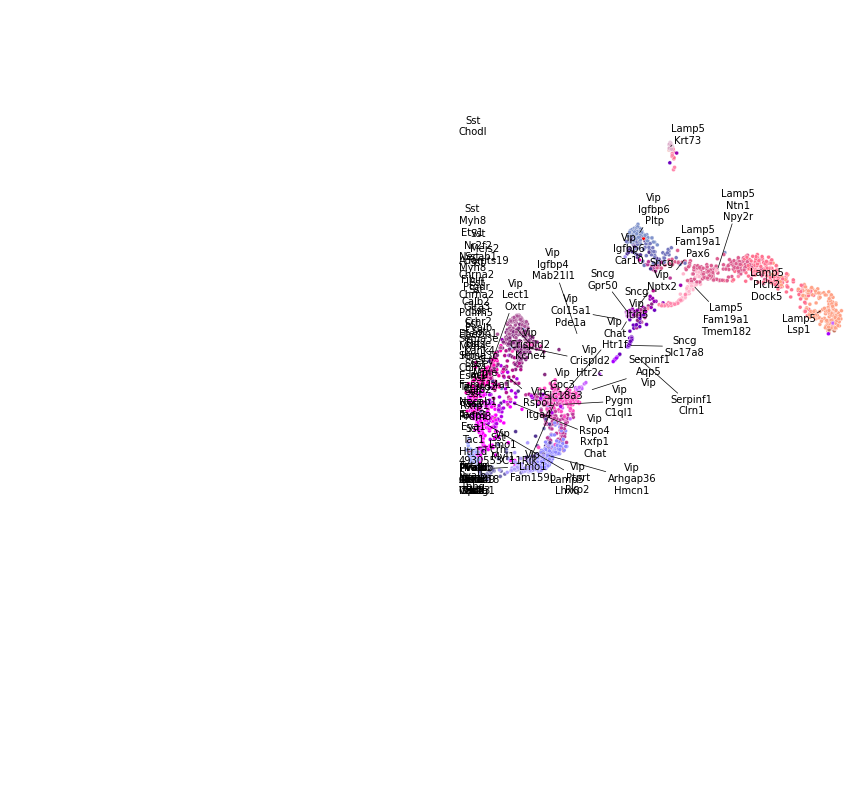

In [320]:
plot_umap_labeled(df.query("species=='mouse'"), x=0, y=1, cluster='cluster', palette=palette_mouse, s=15,
                      figsize=(7,7), xlim=xlim, ylim=ylim, axes=False)

<AxesSubplot:xlabel='0', ylabel='1'>

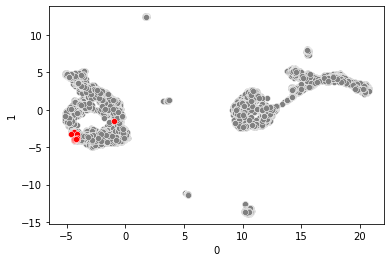

In [115]:
sns.scatterplot(data=df, x=0, y=1, color='grey', legend=False)
sns.scatterplot(data=df.loc[df.cluster.str.contains('LHX6')], x=0, y=1, color='red', legend=False)

### Densmap

In [52]:
umap = UMAP(densmap=True).fit_transform(aligned)

In [53]:
umap = pd.DataFrame(umap, index=aligned.index)

df = umap.join(combined)
df_l1 = df.loc[lambda df: df.cluster.isin(l1_types_human+l1_types_mouse)]

In [54]:
xlim=[9,21]
ylim=[-3, 9]
xlim=[None, None]
ylim=xlim

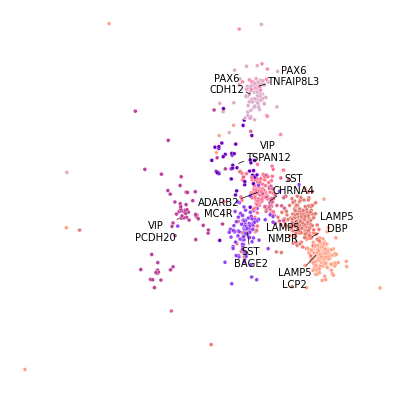

In [55]:
plot_umap_labeled(df_l1.query("species=='human'"), x=0, y=1, cluster='cluster', palette=palette_human, s=15,
                      figsize=(7,7), xlim=xlim, ylim=ylim, axes=False)

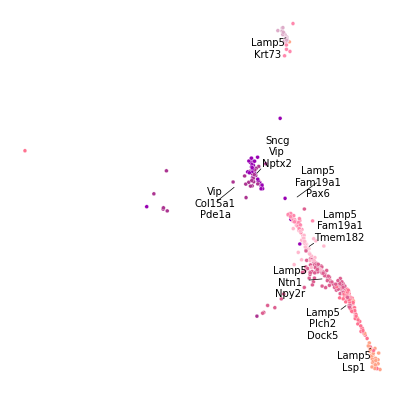

In [56]:
palette = palette_mouse
# palette["Lamp5 Fam19a1 Pax6 "] = palette["Lamp5 Fam19a1 Pax6"]
# df_l1.loc[(df.cluster=='Lamp5 Fam19a1 Pax6') & (df_l1[1]>7), 'cluster'] = "Lamp5 Fam19a1 Pax6 "

plot_umap_labeled(df_l1.query("species=='mouse'"), x=0, y=1, cluster='cluster', palette=palette, s=15,
                      figsize=(7,7), xlim=xlim, ylim=ylim, axes=False)

Text(0, 0.5, '')

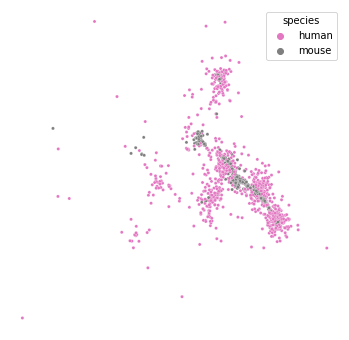

In [57]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_l1.sample(frac=1), x=0, y=1, hue='species', palette=species_palette, s=10, legend=True)
plt.xlim(xlim)
plt.ylim(ylim)
sns.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

# Seurat embed

In [29]:
path = "/home/tom.chartrand/projects/MTG_celltypes_dev/data/cca/cell_embeddings_inh.rda"
data = pyreadr.read_r(path)
seurat = data['cell_embeddings']

In [78]:
coords = seurat
index_mouse = (mouse_df.
               loc[lambda df: df.sample_id.isin(aligned.index)].
               loc[lambda df: df.subclass.isin(['Lamp5', 'Vip', 'Sncg'])].
               groupby('cluster').sample_id.apply(list))
index_human = (human_df.
               loc[lambda df: df.sample_id.isin(aligned.index)].
               loc[lambda df: df.cell_subclass.isin(['LAMP5/PAX6/Other', 'VIP'])].
               groupby('cluster').sample_id.apply(list))

In [42]:
between, within = get_distances(coords, index_row=index_human, index_col=index_mouse)

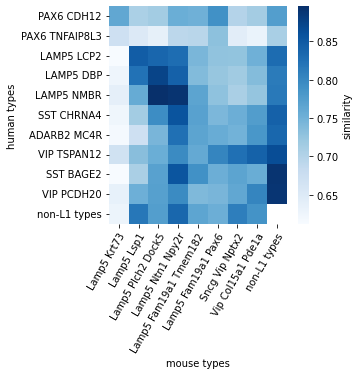

In [43]:
df = within/between
plot_l1_hom(df)

In [417]:
human_df['homology_type'] = human_df['cluster'].map(homology_mapping_human).fillna(human_df['cluster'])
human_df.loc[lambda df: df['homology_type']=='other', 'homology_type'] = human_df.loc[
    lambda df: df['homology_type']=='other', 'cluster'] 
index_human_hom = (human_df.loc[lambda df: df.cell_subclass.isin(['LAMP5/PAX6/Other', 'VIP'])].
               groupby('homology_type').sample_id.apply(list))


In [419]:
between, within = get_distances(aligned, index_row=index_human_hom, index_col=index_mouse)

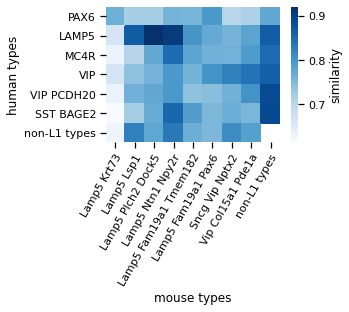

In [420]:
df = within/between
types_human = ['PAX6', 'LAMP5', 'MC4R', 'VIP', 'VIP PCDH20', 'SST BAGE2']
plot_l1_hom(df, types_human=types_human, figsize=(4,2.5))

In [421]:
get_l1_df(df, types_human=types_human)

cluster,Lamp5 Krt73,Lamp5 Lsp1,Lamp5 Plch2 Dock5,Lamp5 Ntn1 Npy2r,Lamp5 Fam19a1 Tmem182,Lamp5 Fam19a1 Pax6,Sncg Vip Nptx2,Vip Col15a1 Pde1a,non-L1 types
homology_type,,,,,,,,,
PAX6,0.764162,0.720540,0.720971,0.759381,0.757818,0.796534,0.704136,0.714262,0.775824
LAMP5,0.666838,0.868445,0.920837,0.907126,0.799606,0.772351,0.759440,0.780727,0.866969
MC4R,0.630445,0.705553,0.773292,0.848186,0.779626,0.763542,0.761879,0.792385,0.849844
VIP,0.667922,0.740946,0.759336,0.796144,0.760406,0.803060,0.824797,0.840921,0.863508
VIP PCDH20,0.634915,0.763132,0.776579,0.796574,0.740406,0.744822,0.762482,0.803432,0.888920
SST BAGE2,0.613457,0.722004,0.769617,0.854998,0.790074,0.753450,0.766623,0.756201,0.890203
non-L1 types,0.628493,0.826915,0.778607,0.835455,0.766031,0.753589,0.810932,0.787406,NaN


### umap

In [59]:
umap = UMAP().fit_transform(coords)

In [59]:
umap = pd.DataFrame(umap, index=coords.index)

df = umap.join(combined)
df_l1 = df.loc[lambda df: df.cluster.isin(l1_types_human+l1_types_mouse)]

In [61]:
xlim=[9,21]
ylim=[-3, 9]
xlim=[None, None]
ylim=xlim

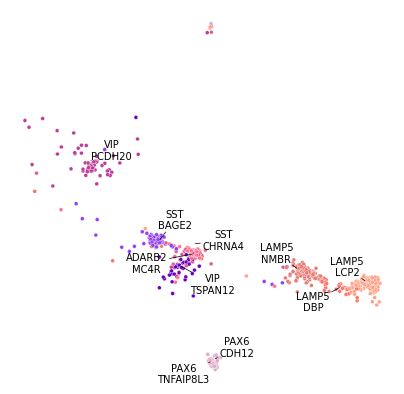

In [62]:
plot_umap_labeled(df_l1.query("species=='human'"), x=0, y=1, cluster='cluster', palette=palette_human, s=15,
                      figsize=(7,7), xlim=xlim, ylim=ylim, axes=False)

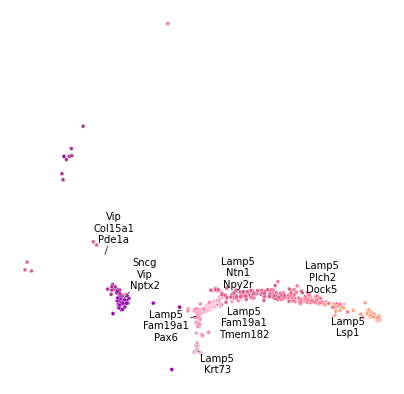

In [63]:
palette = palette_mouse
# palette["Lamp5 Fam19a1 Pax6 "] = palette["Lamp5 Fam19a1 Pax6"]
# df_l1.loc[(df.cluster=='Lamp5 Fam19a1 Pax6') & (df_l1[1]>7), 'cluster'] = "Lamp5 Fam19a1 Pax6 "

plot_umap_labeled(df_l1.query("species=='mouse'"), x=0, y=1, cluster='cluster', palette=palette, s=15,
                      figsize=(7,7), xlim=xlim, ylim=ylim, axes=False)

Text(0, 0.5, '')

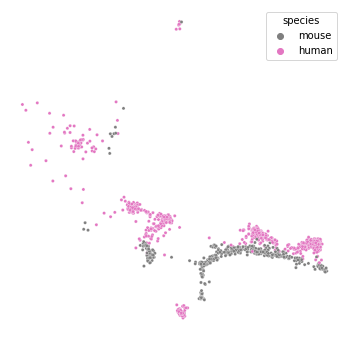

In [64]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_l1.sample(frac=1), x=0, y=1, hue='species', palette=species_palette, s=10, legend=True)
plt.xlim(xlim)
plt.ylim(ylim)
sns.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

### Densmap

In [65]:
umap = UMAP(densmap=True).fit_transform(seurat)

In [66]:
umap = pd.DataFrame(umap, index=seurat.index)
df = umap.join(combined)
df_l1 = df.loc[lambda df: df.cluster.isin(l1_types_human+l1_types_mouse)]

In [73]:
xlim=[9,21]
ylim=[2,16]
# xlim=[None, None]
# ylim=xlim

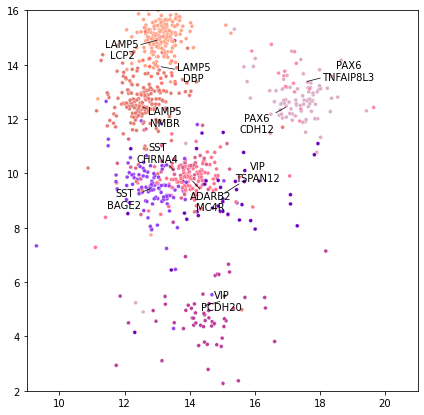

In [74]:
plot_umap_labeled(df_l1.query("species=='human'"), x=0, y=1, cluster='cluster', palette=palette_human, s=15,
                      figsize=(7,7), xlim=xlim, ylim=ylim, axes=True)

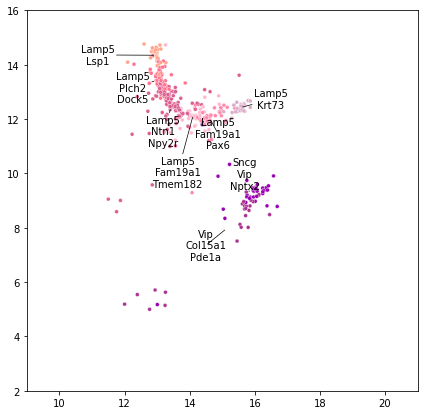

In [75]:
palette = palette_mouse
# palette["Lamp5 Fam19a1 Pax6 "] = palette["Lamp5 Fam19a1 Pax6"]
# df_l1.loc[(df.cluster=='Lamp5 Fam19a1 Pax6') & (df_l1[1]>7), 'cluster'] = "Lamp5 Fam19a1 Pax6 "

plot_umap_labeled(df_l1.query("species=='mouse'"), x=0, y=1, cluster='cluster', palette=palette, s=15,
                      figsize=(7,7), xlim=xlim, ylim=ylim, axes=True)

Text(0, 0.5, '')

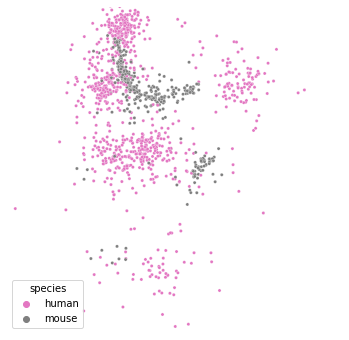

In [76]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_l1.sample(frac=1), x=0, y=1, hue='species', palette=species_palette, s=10, legend=True)
plt.xlim(xlim)
plt.ylim(ylim)
sns.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')

# existing homologies

## Hodge/Bakken replot

In [280]:
names_df = pd.read_csv("../human_l1/human_MTG_cluster_conversion.csv")
names_update = names_df.set_index(names_df['patchseq_cluster'].map(shorten_name))['current_FACS_cluster'].to_dict()

In [281]:
overlap = pd.read_csv("/home/tom.chartrand/projects/human_l1/scAlign_inh_VISp_homologies.csv", index_col=0)
# overlap = overlap.div(overlap.sum(axis=1))

In [282]:
overlap.columns = overlap.columns.map(lambda x: x.split('_')[1])
overlap.index = overlap.index.map(shorten_name).map(names_update).map(shorten_name)

<AxesSubplot:>

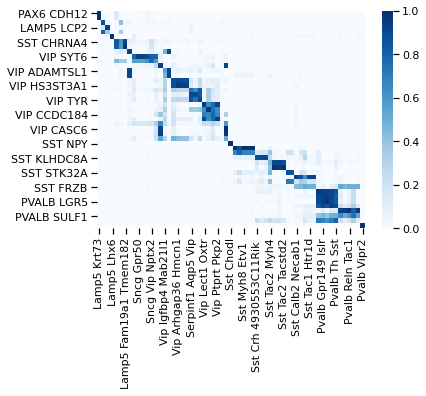

In [283]:
sns.heatmap(overlap, cmap=plt.cm.Blues)

Text(12.499999999999993, 0.5, 'human types')

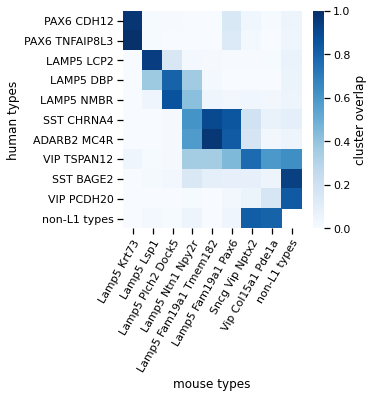

In [284]:
fig, ax = plt.subplots(figsize=(4,4))
# df = overlap.div(overlap.max(axis=1), axis=0)
df = overlap.copy()
df.loc[:,'non-L1 types'] = df.loc[:,df.columns.difference(l1_types_mouse)].max(axis=1)
df.loc['non-L1 types', :] = df.loc[df.index.difference(l1_types_human), df.columns.difference(['non-L1 types'])].max(axis=0)
sns.heatmap(df.loc[list(l1_types_human)+['non-L1 types'], list(l1_types_mouse)+['non-L1 types']], 
            cmap=plt.cm.Blues, cbar_kws=dict(label='cluster overlap'), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right',  rotation_mode='anchor')
ax.set_xlabel('mouse types')
ax.set_ylabel('human types')

# plt.tight_layout()
# plt.savefig(figdir/"homology.pdf", bbox_inches='tight')

In [23]:
overlap = pd.read_csv("/home/tom.chartrand/projects/human_l1/cl.conf.optimal_inh.csv", index_col=0)
# overlap = overlap.div(overlap.sum(axis=1))
overlap.columns = overlap.columns.map(lambda x: x.split('_')[1])
overlap.index = overlap.index.map(shorten_name)

<AxesSubplot:>

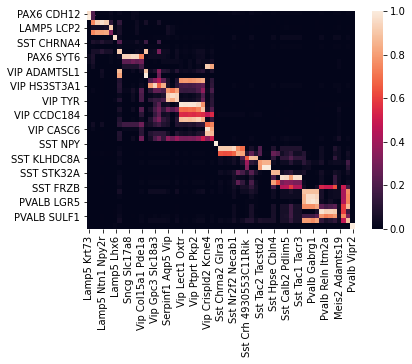

In [24]:
sns.heatmap(overlap, cmap=plt.cm.Blues)

<AxesSubplot:>

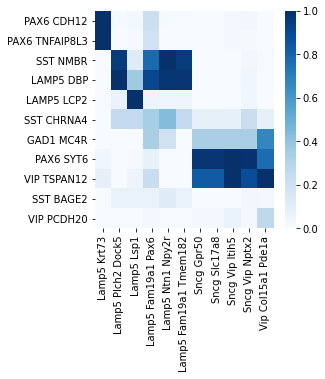

In [34]:
plt.figure(figsize=(4,4))
df = overlap.div(overlap.max(axis=1), axis=0)
sns.heatmap(df.loc[l1_types_human, l1_types_mouse]
            , cmap=plt.cm.Blues)

<AxesSubplot:>

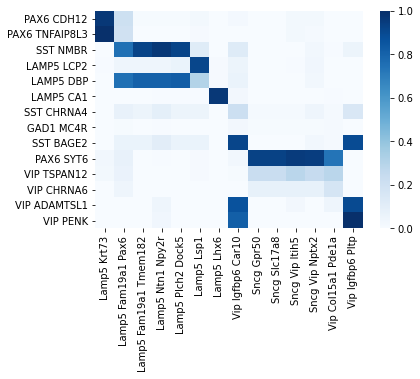

In [52]:
# plt.figure(figsize=(12,8))
# df = overlap.div(overlap.max(axis=1), axis=0)
df = overlap
cols = [x for x in df.columns if 'pvalb' not in x.lower() and 'sst' not in x.lower()]
rows = [x for x in df.index if 'pvalb' not in x.lower() and 'sst' not in x.lower()]
# sns.heatmap(df.loc[rows, cols],
sns.heatmap(df.iloc[:14, :14],
            cmap=plt.cm.Blues)

In [11]:
inh_dist = pd.read_csv('inh_dist.csv', index_col=0)
inh_dist.head()

,Inh L1 SST CHRNA4,Inh L1 SST NMBR,Inh L1-2 GAD1 MC4R,Inh L1-2 LAMP5 DBP,Inh L1-2 PAX6 CDH12,Inh L1-2 PAX6 TNFAIP8L3,Inh L1-2 SST BAGE2,Inh L1-2 VIP LBH,Inh L1-2 VIP PCDH20,Inh L1-2 VIP TSPAN12,...,Inh L4-5 SST STK32A,Inh L4-6 PVALB SULF1,Inh L4-6 SST B3GAT2,Inh L4-6 SST GXYLT2,Inh L5-6 GAD1 GLP1R,Inh L5-6 PVALB LGR5,Inh L5-6 SST KLHDC8A,Inh L5-6 SST MIR548F2,Inh L5-6 SST NPM1P10,Inh L5-6 SST TH
Lamp5 Fam19a1 Pax6,47.317584,52.242262,57.544735,59.714766,16.410185,21.035540,50.087586,63.808729,67.644120,43.486136,...,76.732664,75.903096,76.439792,75.570573,78.770576,76.627406,79.851650,73.369785,74.700760,76.053184
Lamp5 Fam19a1 Tmem182,45.593341,42.484883,55.274208,54.701784,34.355843,35.841448,46.473580,64.126386,69.922195,52.046218,...,77.744365,74.604894,76.735570,74.660193,78.929410,75.910345,80.147200,71.689844,73.584155,76.031549
Lamp5 Krt73,58.681200,59.984990,69.134596,64.619320,27.529822,27.232534,63.674745,73.773815,75.443226,59.088925,...,79.626398,77.847342,78.874170,78.088731,81.668142,80.411551,83.414914,75.799521,77.234928,79.325831
Lamp5 Lhx6,62.869886,51.985479,69.100321,45.011826,64.465998,63.825877,66.490667,73.393450,74.077549,70.645466,...,72.662097,64.995669,74.478550,73.366980,74.106103,70.804136,77.766590,62.893808,71.733116,71.614117
Lamp5 Lsp1,59.445183,38.241305,66.728826,24.346718,57.259191,56.805663,63.672084,72.876041,73.191947,68.521886,...,73.519744,68.013330,74.613142,73.177632,75.435235,72.929330,77.622594,65.629324,71.547498,71.652001


<AxesSubplot:>

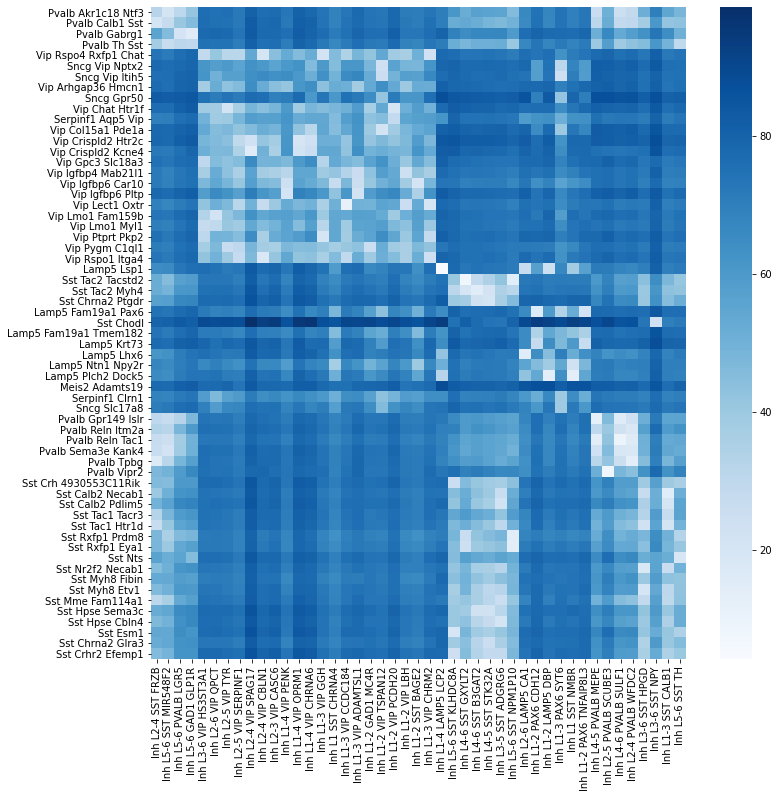

In [33]:
data = inh_dist.values
model = SpectralCoclustering(n_clusters=7, random_state=0)
model.fit(1/data)

# fit_data = data[np.argsort(model.row_labels_)]
fit_data = inh_dist.iloc[np.argsort(model.row_labels_), np.argsort(model.column_labels_)]

plt.figure(figsize=(12,12))
sns.heatmap(fit_data, cmap=plt.cm.Blues)
# plt.colorbar()